In [2]:
import numpy as np
import os
import pandas as pd
import torch
import torch.utils.data
import argparse
import time
import csv
import torch.nn as nn
from torch import optim
import math
from torch.autograd import Variable
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from collections import namedtuple
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, PackedSequence
import torch.nn.functional as F
from torch.utils.data.dataloader import _use_shared_memory
import time
from torch.optim.lr_scheduler import StepLR
import re
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import numpy as np
from scipy.io import loadmat
from random import shuffle
from torch.utils.data import Dataset, DataLoader


In [2]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.draw

In [ ]:
conda install scikit-learn
pip install opencv-python

In [6]:
class JHMDB_image(torch.utils.data.Dataset):
    def __init__(self, video_pathes, mask_pathes, pose_pathes, class_names):
        
        self.data = {'image': [], 'label': [], 'mask':[], 'pose':[], 'scale':[]}
        
        self.classdict = {}
        for i, x in enumerate(class_names):
            self.classdict[x] = i

        video_num=len(video_pathes)
        mask_num=len(mask_pathes)

        for i in range(video_num):
            cap = cv2.VideoCapture(video_pathes[i])
            has_frame=True
            frame_cnt = 0
            while(has_frame):
                _, frame = cap.read()
                has_frame = frame is not None

                if has_frame:
                    frame = cv2.resize(frame, (224, 224), interpolation = cv2.INTER_CUBIC) # (112, 112, 3)
                    #frame = np.transpose(frame, (2, 0, 1)) # (3, 112, 112)
                    self.data['image'].append(frame)
                    frame_cnt += 1
            cap.release()
            
            mask_mat = loadmat(mask_pathes[i]) 
            masks = cv2.resize(mask_mat['part_mask'], (224, 224), interpolation = cv2.INTER_CUBIC) # (112, 112, F)
            
            pose_mat = loadmat(pose_pathes[i])['pos_img']
            scale = loadmat(pose_pathes[i])['scale']
            
            for j in range(frame_cnt):
                self.data['mask'].append(masks[:,:,j])
                self.data['label'].append(video_pathes[i].split('/')[-2])

                self.data['pose'].append(pose_mat[:,:,j])
                self.data['scale'].append(scale[0][j]) # redundant dim
            
            
    def _compute_mean(self):
        meanstd_file = './data/jhmdbmean'
        if os.path.isfile(meanstd_file):
            meanstd = torch.load(meanstd_file)
        else:
            #mean = torch.zeros(3)
            #std = torch.zeros(3)
            mean = np.zeros(3)
            std = np.zeros(3)
            cnt = 0
            for videos in self.data['video']:
                for img in videos:
                    # CxHxW
                    mean += np.reshape(img, (-1, img.shape[-1])).mean(0)
                    std += np.reshape(img, (-1, img.shape[-1])).std(0) 
                    cnt += 1
            mean /= cnt
            std /= cnt
            mean = torch.FloatTensor(mean)
            std = torch.FloatTensor(std)
            meanstd = {
                'mean': mean,
                'std': std,
                }
            torch.save(meanstd, meanstd_file)
            
        print('    Mean: %.4f, %.4f, %.4f' % (meanstd['mean'][0], meanstd['mean'][1], meanstd['mean'][2]))
        print('    Std:  %.4f, %.4f, %.4f' % (meanstd['std'][0], meanstd['std'][1], meanstd['std'][2]))
            
        return meanstd['mean'], meanstd['std']
    
    def __getitem__(self, index):
        # image (C, 112, 112) to be reshaped on the fly
        # label scala, 
        # mask (112, 112)
        # pose (2, 15)
        # scale scala
        
        pose_data = torch.from_numpy(self.data['pose'][index].astype('float'))
        
        # change pose position according to resize
        pose_data[0,:] = pose_data[0,:] * 7 / 320
        pose_data[1,:] = pose_data[1,:] * 7 / 240
        
        # features, action_label, mask_label, pose_label, scale
        return torch.from_numpy(np.array(self.data['image'][index])).float(), \
            torch.LongTensor([self.classdict[self.data['label'][index]]]), \
            torch.from_numpy(self.data['mask'][index].astype('float')), \
            pose_data, \
            self.data['scale'][index]
            #torch.FloatTensor([self.data['scale'][index].astype('float')])
        
    def __len__(self):
        return len(self.data['scale'])

In [44]:
class JHMDB_video(torch.utils.data.Dataset):
    def __init__(self, video_pathes, mask_pathes, pose_pathes, class_names):
        
        self.data = {'video': [], 'label': [], 'mask':[], 'pose':[], 'scale':[]}
        
        self.classdict = {}
        for i, x in enumerate(class_names):
            self.classdict[x] = i

        video_num=len(video_pathes)
        mask_num=len(mask_pathes)

        for i in range(video_num):
            video=[]
            cap = cv2.VideoCapture(video_pathes[i])
            has_frame=True
            while(has_frame):
                _, frame = cap.read()
                has_frame = frame is not None

                if has_frame:
                    frame = cv2.resize(frame, (224, 224), interpolation = cv2.INTER_CUBIC) # (112, 112, 3)
                    #frame = np.transpose(frame, (2, 0, 1)) # (3, 112, 112)
                    video.append(frame)
            cap.release()
            self.data['video'].append(video)

            mask_mat = loadmat(mask_pathes[i]) 
            masks = cv2.resize(mask_mat['part_mask'], (224, 224), interpolation = cv2.INTER_CUBIC) # (112, 112, F)
            self.data['mask'].append(masks)
            self.data['label'].append(video_pathes[i].split('/')[-2])
            pose_mat = loadmat(pose_pathes[i])['pos_img']
            scale = loadmat(pose_pathes[i])['scale']
            self.data['pose'].append(pose_mat)
            self.data['scale'].append(scale[0]) # redundant dim
            
            
    def _compute_mean(self):
        meanstd_file = './data/jhmdbmean'
        if os.path.isfile(meanstd_file):
            meanstd = torch.load(meanstd_file)
        else:
            #mean = torch.zeros(3)
            #std = torch.zeros(3)
            mean = np.zeros(3)
            std = np.zeros(3)
            cnt = 0
            for videos in self.data['video']:
                for img in videos:
                    # CxHxW
                    mean += np.reshape(img, (-1, img.shape[-1])).mean(0)
                    std += np.reshape(img, (-1, img.shape[-1])).std(0) 
                    cnt += 1
            mean /= cnt
            std /= cnt
            mean = torch.FloatTensor(mean)
            std = torch.FloatTensor(std)
            meanstd = {
                'mean': mean,
                'std': std,
                }
            torch.save(meanstd, meanstd_file)
            
        print('    Mean: %.4f, %.4f, %.4f' % (meanstd['mean'][0], meanstd['mean'][1], meanstd['mean'][2]))
        print('    Std:  %.4f, %.4f, %.4f' % (meanstd['std'][0], meanstd['std'][1], meanstd['std'][2]))
            
        return meanstd['mean'], meanstd['std']
    
    def __getitem__(self, index):
        # video (F, 224, 224, C) to be reshaped on the fly
        # label scala, 
        # mask (224, 224, F)
        # pose (2, 15, F)
        # scale (F)
        # 1x40x224x224x3, 1x1, 1x224x224x40, 1x2x15x40
        
        pose_data = torch.from_numpy(self.data['pose'][index].astype('float'))
        
        # change pose position according to resize
        pose_data[0,:,:] = pose_data[0,:,:] * 224 / 320
        pose_data[1,:,:] = pose_data[1,:,:] * 224 / 240
        
        # features, action_label, mask_label, pose_label, scale
        return torch.from_numpy(np.array(self.data['video'][index])).float(), \
            torch.LongTensor([self.classdict[self.data['label'][index]]]), \
            torch.from_numpy(self.data['mask'][index].astype('float')), \
            pose_data, \
            #torch.from_numpy(self.data['scale'][index][selected_frame].astype('float'))
        
    def __len__(self):
        return len(self.data['scale'])

In [40]:

video_rootdir="./ReCompress_Videos"
mask_rootdir="./puppet_mask"
pose_rootdir="./joint_positions"

video_pathes=[]
mask_pathes=[]
pose_pathes=[]
for root, dirs, files in os.walk(video_rootdir):
    for file in files:
        if file[0].startswith(".") or root.endswith('.AppleDouble'):
            continue
        video_pathes.append(os.path.join(root, file))

for root, dirs, files in os.walk(mask_rootdir):
    for file in files:
        if file[0].startswith(".") or root.endswith('.AppleDouble'):
            continue
        mask_pathes.append(os.path.join(root, file)) 

for root, dirs, files in os.walk(pose_rootdir):
    for file in files:
        if file[0].startswith(".") or root.endswith('.AppleDouble'):
            continue
        pose_pathes.append(os.path.join(root, file))    

video_pathes = sorted(video_pathes)
mask_pathes = sorted(mask_pathes)
pose_pathes = sorted(pose_pathes)

video_list = [re.findall(r"[\w_]+\d+", x)[0] for x in video_pathes]
mask_list = [re.findall(r"[\w_]+\d+", x)[0] for x in mask_pathes]
pose_list = [re.findall(r"[\w_]+\d+", x)[0] for x in pose_pathes]

# make sure every thing matches
for x, y, z in zip(video_list, mask_list, pose_list):
    assert (x == y) and (x == z)

video_pathes_train, video_pathes_valid, mask_pathes_train, mask_pathes_valid, pose_pathes_train, pose_pathes_valid = \
    train_test_split(video_pathes, mask_pathes, pose_pathes, test_size=0.2)
class_names=[name for name in os.listdir(video_rootdir) if not name.startswith(".")]


In [8]:
#train_dataset = JHMDB(video_pathes_train, mask_pathes_train, pose_pathes_train, class_names)
#
#train_loader = torch.utils.data.DataLoader(train_dataset,
#    batch_size=10, shuffle=True)
#    #num_workers=2, pin_memory=True)
    
valid_dataset = JHMDB(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=2, shuffle=False) # can't change to anything other than 1
    #num_workers=2, pin_memory=True)

NameError: name 'JHMDB' is not defined

In [ ]:
train_dataset = JHMDB_image(video_pathes_train, mask_pathes_train, pose_pathes_train, class_names)

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=10, shuffle=True)
    #num_workers=2, pin_memory=True)

valid_dataset = JHMDB_video(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=1, shuffle=True) # can't change to anything other than 1
    #num_workers=2, pin_memory=True)

In [41]:
valid_dataset = JHMDB_image(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=2, shuffle=True) # can't change to anything other than 1
    #num_workers=2, pin_memory=True)

In [45]:
pose_dataset = JHMDB_video(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

pose_loader = torch.utils.data.DataLoader(pose_dataset,
    batch_size=1, shuffle=False) # can't change to anything other than 1
    #num_workers=2, pin_memory=True)

In [46]:
for x in pose_loader:
    print(x) # 1x40x224x224x3, 1x1, 1x224x224x40, 1x2x15x40
    break

[
( 0 , 0 , 0 ,.,.) = 
    4    6    6
    1    3    3
   11   14   14
       ⋮       
  123  131  130
  122  130  129
  119  127  126

( 0 , 0 , 1 ,.,.) = 
    4    7    7
    0    2    2
    5    8    8
       ⋮       
  124  132  131
  121  129  128
  121  129  128

( 0 , 0 , 2 ,.,.) = 
    7   11   11
    0    0    0
    9   14   14
       ⋮       
  124  132  131
  122  130  129
  121  129  128
        ... 

( 0 , 0 ,221,.,.) = 
   55   65   64
   84   92   95
   65   72   78
       ⋮       
    9   22   38
    6   18   31
    6   16   24

( 0 , 0 ,222,.,.) = 
   22   31   34
   77   83   91
   66   71   82
       ⋮       
    9   22   38
    6   18   31
    6   16   24

( 0 , 0 ,223,.,.) = 
    7   12   16
   67   73   82
   73   78   89
       ⋮       
    9   22   38
    6   18   31
    6   16   24
          ⋮  

( 0 , 1 , 0 ,.,.) = 
    4    6    6
    1    3    3
   11   14   14
       ⋮       
  123  131  130
  122  130  129
  119  127  126

( 0 , 1 , 1 ,.,.) = 
    4    7  

In [103]:
for x in valid_loader:
    print(x)
    break

[
( 0 , 0 ,.,.) = 
   64   88   78
   72   96   86
   50   74   64
       ⋮       
   30   46   39
   30   46   39
   25   41   34

( 0 , 1 ,.,.) = 
   72   96   86
   72   96   86
   53   77   67
       ⋮       
   39   55   48
   40   56   49
   41   57   50

( 0 , 2 ,.,.) = 
   67   94   84
   61   87   77
   39   65   55
       ⋮       
   33   49   42
   36   52   45
   39   55   48
    ... 

( 0 ,221,.,.) = 
    0    3   32
    0    5   34
    0    0   27
       ⋮       
   70   96  117
   37   65   85
   66   97  118

( 0 ,222,.,.) = 
    2    2   27
    6    5   31
    7    7   32
       ⋮       
   62   96  115
   62   98  117
   84  125  143

( 0 ,223,.,.) = 
    4    3   27
    2    1   24
   19   19   43
       ⋮       
   66  100  120
   83  120  139
   96  138  156
      ⋮  

( 1 , 0 ,.,.) = 
   47   71   61
   38   62   52
   58   82   72
       ⋮       
   24   41   32
   15   32   23
   18   35   26

( 1 , 1 ,.,.) = 
   65   89   79
   59   83   73
   69   93   83
    

In [205]:
print(len(video_pathes_valid))

186


In [18]:
print((valid_dataset.data['scale']))

[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6499999999999999, 0.6499999999999999, 0.6499999999999999, 0.6499999999999999, 0.6499999999999999, 0.5999999999999999, 0.5999999999999999, 0.5999999999999999, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

In [129]:
for x in valid_loader:
    # transpose 
    x_size = x[0].size()
    #print(x[0].view(x_size[0] * x_size[1], x_size[2], x_size[3], x_size[4]))
    #x_size = x[0].transpose(4,3).transpose(3,2).transpose(2,1).size()
    #print(x[0].transpose(4,3).transpose(3,2).transpose(2,1).contiguous().view(x_size[0] * x_size[1], x_size[2], x_size[3], x_size[4]))
    for t in x[1:]:
        print(t.size())
    
    break

video [[[ 15 105  66]
  [ 25 113  75]
  [ 11  98  60]
  ...
  [ 36  52  39]
  [140 157 143]
  [ 92 111  97]]

 [[ 28 116  77]
  [  5  93  55]
  [  0  77  39]
  ...
  [ 39  55  42]
  [ 98 114 101]
  [ 40  58  45]]

 [[ 25  88  58]
  [  5  75  44]
  [  0  64  33]
  ...
  [ 24  36  28]
  [ 38  50  42]
  [  2  13   6]]

 ...

 [[ 21 137  82]
  [ 14 130  75]
  [ 27 143  88]
  ...
  [ 34 166 101]
  [ 46 179 114]
  [ 47 180 115]]

 [[ 18 134  79]
  [ 12 128  73]
  [ 30 146  91]
  ...
  [ 23 156  91]
  [ 27 160  95]
  [ 32 165 100]]

 [[ 15 131  76]
  [ 11 127  72]
  [ 32 148  93]
  ...
  [ 17 150  85]
  [ 13 146  81]
  [ 19 152  87]]]
video [[[ 30  50  76]
  [ 38  65 107]
  [ 71 103 153]
  ...
  [ 11  16  34]
  [  9  14  31]
  [  7  11  27]]

 [[ 31  52  78]
  [ 38  66 108]
  [ 74 105 155]
  ...
  [  9  14  32]
  [  9  13  31]
  [  6  10  26]]

 [[ 31  52  81]
  [ 40  68 111]
  [ 76 107 157]
  ...
  [  8  14  30]
  [  8  13  29]
  [  6  10  26]]

 ...

 [[ 26  53  86]
  [ 62  94 135]
  [ 64  

In [47]:
# use some code from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['resnet101']


model_urls = {
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)

        return x




def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


In [10]:
ResnetModel = resnet101(True)

In [11]:
print(ResnetModel)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1):

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

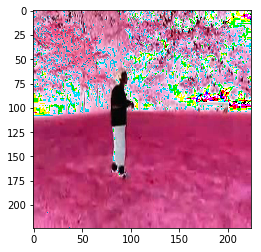

In [151]:
for x in valid_loader:
    #print(x[0][0][0])
    #img_ = Image.fromarray(x[0][0][0].numpy(), 'RGB')
    #img_.show()
    imgplot = plt.imshow(x[0][0][0].numpy())
    break

In [136]:
video=[]
cap = cv2.VideoCapture(video_pathes_valid[0])
has_frame=True
while(has_frame):
    _, frame = cap.read()
    has_frame = frame is not None

    if has_frame:
        frame = cv2.resize(frame, (224, 224), interpolation = cv2.INTER_CUBIC) # (112, 112, 3)
        #frame = np.transpose(frame, (2, 0, 1)) # (3, 112, 112)
        video.append(frame)
cap.release()


In [137]:
print(video[0])

[[[ 15 105  66]
  [ 25 113  75]
  [ 11  98  60]
  ...
  [ 36  52  39]
  [140 157 143]
  [ 92 111  97]]

 [[ 28 116  77]
  [  5  93  55]
  [  0  77  39]
  ...
  [ 39  55  42]
  [ 98 114 101]
  [ 40  58  45]]

 [[ 25  88  58]
  [  5  75  44]
  [  0  64  33]
  ...
  [ 24  36  28]
  [ 38  50  42]
  [  2  13   6]]

 ...

 [[ 21 137  82]
  [ 14 130  75]
  [ 27 143  88]
  ...
  [ 34 166 101]
  [ 46 179 114]
  [ 47 180 115]]

 [[ 18 134  79]
  [ 12 128  73]
  [ 30 146  91]
  ...
  [ 23 156  91]
  [ 27 160  95]
  [ 32 165 100]]

 [[ 15 131  76]
  [ 11 127  72]
  [ 32 148  93]
  ...
  [ 17 150  85]
  [ 13 146  81]
  [ 19 152  87]]]


In [138]:
img_ = Image.fromarray(video[0], 'RGB')
img_.show()

In [134]:
for features, action_label, mask, pose in valid_loader:
    #print(features, pose)
    print(features[0, 0].numpy().astype('int'))
    img_ = Image.fromarray(features[0, 0].numpy().astype('int'), 'RGB')
    img_.show()
    break

video [[[ 15 105  66]
  [ 25 113  75]
  [ 11  98  60]
  ...
  [ 36  52  39]
  [140 157 143]
  [ 92 111  97]]

 [[ 28 116  77]
  [  5  93  55]
  [  0  77  39]
  ...
  [ 39  55  42]
  [ 98 114 101]
  [ 40  58  45]]

 [[ 25  88  58]
  [  5  75  44]
  [  0  64  33]
  ...
  [ 24  36  28]
  [ 38  50  42]
  [  2  13   6]]

 ...

 [[ 21 137  82]
  [ 14 130  75]
  [ 27 143  88]
  ...
  [ 34 166 101]
  [ 46 179 114]
  [ 47 180 115]]

 [[ 18 134  79]
  [ 12 128  73]
  [ 30 146  91]
  ...
  [ 23 156  91]
  [ 27 160  95]
  [ 32 165 100]]

 [[ 15 131  76]
  [ 11 127  72]
  [ 32 148  93]
  ...
  [ 17 150  85]
  [ 13 146  81]
  [ 19 152  87]]]
video [[[ 30  50  76]
  [ 38  65 107]
  [ 71 103 153]
  ...
  [ 11  16  34]
  [  9  14  31]
  [  7  11  27]]

 [[ 31  52  78]
  [ 38  66 108]
  [ 74 105 155]
  ...
  [  9  14  32]
  [  9  13  31]
  [  6  10  26]]

 [[ 31  52  81]
  [ 40  68 111]
  [ 76 107 157]
  ...
  [  8  14  30]
  [  8  13  29]
  [  6  10  26]]

 ...

 [[ 26  53  86]
  [ 62  94 135]
  [ 64  

In [48]:
def to_tensor(numpy_array, datatype):
    # Numpy array -> Tensor
    if datatype == 'int':
        return torch.from_numpy(numpy_array).int()
    elif datatype == 'long':
        return torch.from_numpy(numpy_array).long()
    else:
        return torch.from_numpy(numpy_array).float()


def to_variable(tensor, cpu=False):
    # Tensor -> Variable (on GPU if possible)
    #print(type(tensor))
    if torch.cuda.is_available() and not cpu:
        # Tensor -> GPU Tensor
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)

In [74]:
class LSTMModel(torch.nn.Module):
    '''
    Paper: Listen, attend and spell
    '''
    def __init__(self, args, dataloader, valid_dataloader):
        super(LSTMModel, self).__init__()
        
        num_pose_keypoints = 15
        NUM_CLASSES = 393
        self.dropout = 0.5
        
        self.ResnetModel = resnet101(True)
        
        self.BU_attention = nn.Conv2d(2048, 1, (1, 1))
        
        #self.pose_pre_logits = nn.Conv2d(2048, 768, (1, 1))
        #self.relu_layer = nn.ReLU()
        #self.pose_logits = nn.Conv2d(768, num_pose_keypoints, (1, 1))
        #self.dropout_layer = nn.Dropout(self.dropout)

        self.TD_attention = nn.Conv2d(2048 + num_pose_keypoints, NUM_CLASSES, (1, 1))
        #self.TD_attention = nn.Conv2d(2048, NUM_CLASSES, (1, 1))

        # initialization
        #self.apply(wsj_initializer)
        
        self.args = args
        self.dataloader = dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion_action_xentropyloss = nn.CrossEntropyLoss()
        self.criterion_pose_l2loss = nn.MSELoss()
        self.best_validation_acc = 0.
        self.model_param_str = 'weights'
        self.optimizer = optim.Adam(self.parameters(), lr=args.init_lr)
        self.k = 10

        if torch.cuda.is_available():
            self.cuda()

    def adjust_lr(self, epoch):
        lr = self.args.init_lr * (0.1 ** (epoch // self.k))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        print("----------adjusting learning rate: {}----------".format(lr))

    def forward(self, input_features, pose_heatmaps):
        start_time = time.time()
        
        # resnet extract feature
        extracted_features = self.ResnetModel(input_features) # (B, 2048, 7, 7)
        
        # bottom up
        BU_logits = self.BU_attention(extracted_features)
        
        # top down
        #pre_pose_logits = self.relu_layer(self.pose_pre_logits(extracted_features))
        #pose_logits = self.pose_logits(pre_pose_logits) # (B, 16, 7, 7)
        
        # append extracted features
        #pose_logits_with_extracted_features = self.dropout_layer(torch.cat((extracted_features, pose_heatmaps), 1))
        pose_logits_with_extracted_features = torch.cat((extracted_features, pose_heatmaps), 1)
        TD_logits = self.TD_attention(pose_logits_with_extracted_features)
        
        #TD_logits = self.TD_attention(extracted_features)
        
        pre_logits = BU_logits * TD_logits
        action_score = torch.mean(pre_logits.view(pre_logits.size(0), pre_logits.size(1), -1), dim=2)

        decoder_time = time.time()
        #print("--- decoder %s seconds ---" % (decoder_time - encoder_time))
        # (B, 393), (B, 16, 7, 7)
        return action_score

    def model_train(self, freeze=True, use_mask=False):
        if freeze:
            print("--------freeze--------")
            for param in self.ResnetModel.parameters():
                param.requires_grad = False
        else:
            print("--------unfreeze--------")
            for param in self.ResnetModel.parameters():
                param.requires_grad = True
        
        for i in range(self.args.start_epoch, self.args.epochs):
            print("---------epoch {}---------".format(i))
            start_time = time.time()
            self.train()

            self.adjust_lr(i)

            losses = 0
            total_cnt = 0
            
            for features, action_label, mask, pose, scale in self.dataloader: # TODO: change back
                fwd_time = time.time()
                self.zero_grad()
        
                # change to frame level prediction
                features = features.contiguous().transpose(3, 2).transpose(2, 1).contiguous()
                #f_size = features.size()
                #features = features.view(f_size[0] * f_size[1], f_size[2], f_size[3], f_size[4])
                features = to_variable(features)
                #print(features.size()) # (B, 3, 224, 224)
                
                # apply hard attention using mask
                if use_mask:
                    # mask (B, 224, 224)
                    mask = mask.unsqueeze(1)
                    mask = mask.expand_as(features)

                    import pdb; pdb.set_trace()
                    visualize_tensor(features[0].data)
                    features = features * to_variable(mask)
                    visualize_tensor(features[0].data)
                    
                # apply hard attention using pose
                pose_heatmaps = []
                # calculate gaussian independently, sum over, clip
                # pose (B, 2, 15)
                #pose = pose.transpose(1, 2).transpose(2, 3).transpose(1, 2).contiguous() # (B, F, 15, 2)
                pose = pose.transpose(1, 2).contiguous() # (B, 15, 2)
                p_size = pose.size()
                #pose = pose.view(p_size[0] * p_size[1], p_size[2], p_size[3]).numpy() # (B x F, 15, 2)

                # should be heatmap of shape (B, 224, 224)
                for scale_idx, pose_15 in enumerate(pose):
                    pose_heatmap = np.zeros((15, 7, 7))
                    for idx, pose_pt in enumerate(pose_15):
                        img = np.zeros((7, 7))
                        #pose_heatmap[i] = gaussian(img, pose_pt, self.args.sigma)
                        pose_heatmap[idx] = circle(img, pose_pt, 1, 1)

                    #pose_heatmap = pose_heatmap.sum(0, keepdims=True).clip(0, 1)
                    pose_heatmaps.append(pose_heatmap)
                pose_heatmaps = to_variable(torch.from_numpy(np.array(pose_heatmaps)).float())
                
                #print(pose_heatmaps)
                
                #F = 15
                #action_label = action_label.repeat(1,F).view(-1)
                action_label = action_label.view(-1)
                action_score = self.forward(features, pose_heatmaps)

                action_xentropyloss = self.criterion_action_xentropyloss(action_score, to_variable(action_label))
                loss = action_xentropyloss
                # TODO: only for valid bit is 1
                #pose_L2loss = self.criterion_pose_l2loss(pose_logits, to_variable(pose_label))
                #loss = action_xentropyloss + pose_L2loss
                
                total_cnt += 1
                losses += loss.data[0]
                print("epoch {}, loss: {}".format(i, loss.data[0]))

                #bwd_time = time.time()
                #print("--- fwd %s seconds ---" % (bwd_time - fwd_time)) 
                
                loss.backward() 

                self.optimizer.step()
                #print("--- bwd %s seconds ---" % (time.time() - bwd_time))  
            print("training loss: {}".format(losses / total_cnt))
            validation_acc = self.evaluate()
            
            print("--------saving model--------")
            self.model_param_str = \
                'att_img_pose_epoch_{}_loss_{}_valloss_{}'.format(
                    i, losses / total_cnt, validation_acc)
            torch.save(self.state_dict(), self.model_param_str + '.t7')
            if validation_acc > self.best_validation_acc:
                self.best_validation_acc = validation_acc

            print("--- %s seconds ---" % (time.time() - start_time))    

        return self.model_param_str     
    def evaluate(self):
        self.eval()

        #losses = 0
        total_cnt = 0
        true = 0
        false = 0
        for features, action_label, _, pose in self.valid_dataloader:
            # 1x40x224x224x3, 1x1, 1x224x224x40, 1x2x15x40
            features = features[0]
            pose = pose[0]
            
            # change to frame level prediction
            #features = features.contiguous().transpose(4, 3).transpose(3, 2).contiguous()
            #f_size = features.size()
            #features = features.view(f_size[0] * f_size[1], f_size[2], f_size[3], f_size[4])
            ##print(features.size()) # (B * F, 3, 224, 224)
            features = features.contiguous().transpose(3, 2).transpose(2, 1).contiguous()
            features = to_variable(features)
            
            # apply hard attention using pose
            pose_heatmaps = []
            # calculate gaussian independently, sum over, clip
            # pose (2, 15, 40)
            #pose = pose.transpose(1, 2).transpose(2, 3).transpose(1, 2).contiguous() # (B, F, 15, 2)
            print("pose", pose.size())
            pose = pose.transpose(1, 2).transpose(0, 1).transpose(1, 2).contiguous() # (B, 15, 2)
            p_size = pose.size()
            #pose = pose.view(p_size[0] * p_size[1], p_size[2], p_size[3]).numpy() # (B x F, 15, 2)

            print("p_size", p_size) # 40, 15, 2
            # should be heatmap of shape (B, 224, 224)
            for scale_idx, pose_15 in enumerate(pose):
                pose_heatmap = np.zeros((15, 7, 7))
                for idx, pose_pt in enumerate(pose_15):
                    img = np.zeros((7, 7))
                    #pose_heatmap[i] = gaussian(img, pose_pt, self.args.sigma)
                    pose_heatmap[idx] = circle(img, pose_pt, 1, 1)

                #pose_heatmap = pose_heatmap.sum(0, keepdims=True).clip(0, 1)
                pose_heatmaps.append(pose_heatmap)
            pose_heatmaps = to_variable(torch.from_numpy(np.array(pose_heatmaps)).float())

            #F = 15
            #action_label = action_label.repeat(1,F).view(-1)
            action_label = action_label.view(-1)
            action_score = self.forward(features, pose_heatmaps)

            #action_xentropyloss = self.criterion_action_xentropyloss(action_score, to_variable(action_label))
            #loss = action_xentropyloss

            #total_cnt += 1
            #losses += loss.data[0]
            #print("validation loss: {}".format(loss.data[0]))
            
            print("action_score", action_score.size())
            action = torch.mean(action_score, dim=0, keepdim=True)
            action = torch.max(action, dim=1)[1]
            action = action.data
            
            print("action: ", action, action_label)
            if action.data.cpu()[0] == action_label[0]:
                true += 1
            else:
                false += 1

        #losses /= total_cnt
        #print("validation loss: {}".format(losses))
        acc = true / (true + false)
        print("validation accuracy: {}".format(acc))
        return acc 

In [75]:
args = namedtuple('args',
                      [
                          'batch_size',
                          'save_directory',
                          'epochs',
                          'start_epoch',
                          'init_lr',
                          'sigma',
                          'radius',
                          'cuda'])(
        5,
        'output/',
        40,
        0,
        1e-4,
        7,
        7,
        False)

model = LSTMModel(args, valid_loader, pose_loader)

In [76]:
model.evaluate()

pose torch.Size([2, 15, 40])
p_size torch.Size([40, 15, 2])
action_score torch.Size([40, 393])
action:  
 189
[torch.LongTensor of size 1]
 
 20
[torch.LongTensor of size 1]

pose torch.Size([2, 15, 40])
p_size torch.Size([40, 15, 2])


KeyboardInterrupt: 

In [14]:
def visualize_tensor(x):
    if x.size(0) == 3:
        x = x.transpose(0, 1).transpose(1, 2)
    imgplot = plt.imshow(x.numpy())

In [111]:
for features, action_label, mask, pose in valid_loader:
    #print(features, pose)
    print(features[0, 0].numpy().astype('int'))
    img_ = Image.fromarray(features[0, 0].numpy().astype('int'), 'RGB')
    img_.show()
    break

[[[ 15 105  66]
  [ 25 113  75]
  [ 11  98  60]
  ...
  [ 36  52  39]
  [140 157 143]
  [ 92 111  97]]

 [[ 28 116  77]
  [  5  93  55]
  [  0  77  39]
  ...
  [ 39  55  42]
  [ 98 114 101]
  [ 40  58  45]]

 [[ 25  88  58]
  [  5  75  44]
  [  0  64  33]
  ...
  [ 24  36  28]
  [ 38  50  42]
  [  2  13   6]]

 ...

 [[ 21 137  82]
  [ 14 130  75]
  [ 27 143  88]
  ...
  [ 34 166 101]
  [ 46 179 114]
  [ 47 180 115]]

 [[ 18 134  79]
  [ 12 128  73]
  [ 30 146  91]
  ...
  [ 23 156  91]
  [ 27 160  95]
  [ 32 165 100]]

 [[ 15 131  76]
  [ 11 127  72]
  [ 32 148  93]
  ...
  [ 17 150  85]
  [ 13 146  81]
  [ 19 152  87]]]


In [51]:
model.model_train(freeze=True, use_mask=False)

--------freeze--------
---------epoch 0---------
----------adjusting learning rate: 0.0001----------
epoch 0, loss: 5.996458053588867
epoch 0, loss: 5.920614719390869
epoch 0, loss: 6.044841289520264
epoch 0, loss: 5.975126266479492


KeyboardInterrupt: 

In [94]:
pose = torch.Tensor(7, 2, 15, 10).uniform_(-1, 1)
print(pose)


(0 ,0 ,.,.) = 
 -0.5778 -0.2301  0.5131  ...  -0.9622  0.6637 -0.3907
 -0.9698 -0.4050  0.6201  ...  -0.1515 -0.2185 -0.0448
 -0.8070  0.9307  0.2862  ...   0.1236 -0.2798  0.4965
           ...             ⋱             ...          
 -0.1078 -0.2271  0.2887  ...  -0.0069  0.5546  0.2986
  0.0381 -0.1986  0.2741  ...   0.7276  0.7518  0.0103
 -0.2135  0.8300 -0.3002  ...   0.7213 -0.9244 -0.0758

(0 ,1 ,.,.) = 
  0.7293 -0.9572  0.8606  ...  -0.2450  0.5358 -0.6409
  0.9495 -0.0388 -0.5200  ...   0.5947  0.1533 -0.9701
 -0.1762  0.9998 -0.0633  ...  -0.5152  0.1039 -0.9500
           ...             ⋱             ...          
 -0.0230  0.4827  0.3084  ...  -0.1932 -0.8979 -0.4939
 -0.4634 -0.1970  0.0906  ...   0.8423 -0.3197 -0.4517
  0.2434  0.8317 -0.0543  ...   0.0592  0.1197  0.6409
     ⋮ 

(1 ,0 ,.,.) = 
  0.5888  0.7839  0.5415  ...   0.3168 -0.8387 -0.2299
 -0.3146  0.3337  0.7052  ...  -0.6618 -0.8615  0.6598
  0.2216  0.7616 -0.4832  ...  -0.3181  0.1196 -0.9551
         

In [92]:
F = 10
sigma = 5

In [152]:
# calculate gaussian independently, sum over, clip
# pose (B, 2, 15, F)
pose = pose.transpose(1, 2).transpose(2, 3).transpose(1, 2).contiguous() # (B, F, 15, 2)
p_size = pose.size()
pose = pose.view(p_size[0] * p_size[1], p_size[2], p_size[3]).numpy() # (B x F, 15, 2)
# should be heatmap of shape (B x F, 224, 224)
pose_heatmaps = []
for pose_15 in pose:
    pose_heatmap = np.zeros((15, 224, 224))
    for i, pose_pt in enumerate(pose_15):
        img = np.zeros((224, 224))
        pose_heatmap[i] = gaussian(img, pose_pt, sigma)
        
    pose_heatmap = pose_heatmap.sum(0, keepdims=True).clip(0, 1)
    pose_heatmaps.append(pose_heatmap)
pose_heatmaps = np.concatenate(pose_heatmaps, 0)

In [153]:
print(pose_heatmaps.shape)

(30, 224, 224)


In [ ]:
# video (B x F, 3, 224, 224)

In [163]:
print(pose_heatmaps[0][20:24])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 

In [51]:
np.arange(0, 10, 1, float).shape

(10,)

In [54]:
x = np.zeros((10,)).astype('float')
x[5:] = 1.
print(x.shape)

(10,)


In [64]:
def gaussian(img, pt, sigma):
    '''
    2D input img, first dim: y, second dim: x
    generate a gaussian (span 6 sigma), select the part we want
    '''
    # Draw a 2D gaussian

    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        return img

    # Generate circle
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    #x = np.zeros((size,)).astype('float')
    #x[5 * sigma:] = size
    
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

In [74]:
img = np.zeros((10, 10)) 
circle(img, [5, 5], 1, 4)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
def circle(img, pt, color, radius):
    # Draw a circle
    # Mostly a convenient wrapper for skimage.draw.circle

    rr, cc = skimage.draw.circle(pt[1], pt[0], radius, img.shape)
    img[rr, cc] = color
    return img

In [36]:
def gaussian(img, pt, sigma):
    '''
    2D input img, first dim: y, second dim: x
    generate a gaussian (span 6 sigma), select the part we want
    '''
    # Draw a 2D gaussian

    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

In [65]:
img = np.zeros((10, 10))
pt = [5, 5]
sigma = 3

In [66]:
res = gaussian(img, pt, sigma)

In [67]:
print(res)

[[0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341 0.00012341 0.00012341 0.00012341]
 [0.00012341 0.00012341 0.00012341 0.00012341 0.00012341 0.00012341
  0.00012341

In [80]:
from scipy.io import loadmat
x = loadmat('mpii_human_pose_v1_u12_1.mat')
#lon = x['lon']
#lat = x['lat']
# one-liner to read a single variable
#lon = loadmat('mpii_human_pose_v1_u12_1.mat')['lon']

In [101]:
act = loadmat('mpii_human_pose_v1_u12_1.mat')['RELEASE']['act']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [123]:
print(x['RELEASE'][0][0][0][0][0])

(array([[(array(['037454012.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')]), array([[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]],
      dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64))


In [121]:
# print(x['RELEASE'][0][0][0][0][index][1])
print(x['RELEASE'][0][0][0][0][0][1])

[[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]]
